In [1]:
import json
import re

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from textblob import TextBlob
from joblib import load

from sklearn import metrics
from sklearn.model_selection import train_test_split

import text_clf

In [2]:
with open("../dataset/IMDB/IMDB_reviews.json") as json_file:
    data = pd.DataFrame(json.loads('[' + ',\n'.join(json_file.readlines()) + ']'))

In [7]:
data

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"
...,...,...,...,...,...,...,...
573908,8 August 1999,tt0139239,ur0100166,False,"Go is wise, fast and pure entertainment. Assem...",10,The best teen movie of the nineties
573909,31 July 1999,tt0139239,ur0021767,False,"Well, what shall I say. this one´s fun at any ...",9,Go - see the movie
573910,20 July 1999,tt0139239,ur0392750,False,"Go is the best movie I have ever seen, and I'v...",10,It's the best movie I've ever seen
573911,11 June 1999,tt0139239,ur0349105,False,Call this 1999 teenage version of Pulp Fiction...,3,Haven't we seen this before?


# Preprocess

In [9]:
x = data['review_text'].values
y = data['is_spoiler'].values

In [10]:
del data

In [14]:
for id, i in tqdm(enumerate(x), total=len(x)):
    text = re.sub(r'http\S+', '', i.lower())
    # text = str(TextBlob(text).correct())
    x[id] = text

100%|██████████| 573913/573913 [00:02<00:00, 268345.25it/s]


In [15]:
prep_data = pd.DataFrame([x,y], index=['text', 'target']).T
prep_data = prep_data[~(prep_data['text'] == '')]
#prep_data = prep_data[prep_data.apply(lambda x: len(x[0]) <= 500, axis=1)]

In [16]:
train, test = train_test_split(prep_data, test_size=0.2)

In [18]:
train.to_csv('dataset/IMDB_train.csv', index=False)
test.to_csv('dataset/IMDB_test.csv', index=False)

# TF-IDF baseline

In [20]:
model, target_names_mapping = text_clf.train(path_to_config='baseline_config_IMDB.yaml')

text-clf-train - INFO - Config:

seed: 42
path_to_save_folder: models
experiment_name: model

# data
data:
  train_data_path: dataset/IMDB_train.csv
  test_data_path: dataset/IMDB_test.csv
  sep: ','
  text_column: text
  target_column: target

# preprocessing
# (included in resulting model pipeline, so preserved for inference)
preprocessing:
  lemmatization: null  # pymorphy2

# tf-idf
tf-idf:
  lowercase: true
  ngram_range: (1, 1)
  max_df: 0.5
  min_df: 1

# logreg
logreg:
  penalty: l2
  C: 1.0
  class_weight: balanced
  solver: saga
  n_jobs: -1

# grid-search
grid-search:
  do_grid_search: false
  grid_search_params_path: hyperparams.py
text-clf-train - INFO - Loading data...
text-clf-train - INFO - Train dataset size: 459130
text-clf-train - INFO - Test dataset size: 114783
text-clf-train - INFO - Fitting TF-IDF + LogReg model...
[Pipeline] ............ (step 1 of 2) Processing tf-idf, total= 1.3min
[Pipeline] ............ (step 2 of 2) Processing logreg, total=  28.5s
text-clf

# ROC AUC

In [21]:
model = load('models/model_IMDB_trained/model.joblib')

In [22]:
print(model)

Pipeline(steps=[('tf-idf', TfidfVectorizer(max_df=0.5)),
                ('logreg',
                 LogisticRegression(class_weight='balanced', n_jobs=-1,
                                    random_state=42, solver='saga'))],
         verbose=True)


In [23]:
test_set = pd.read_csv('dataset/IMDB_test.csv')
x = test_set['text'].astype('U')
y = test_set['target'].to_list()

In [24]:
x_pred = model.predict_proba(test_set['text'].astype('U'))
pred = x_pred[:, 0]

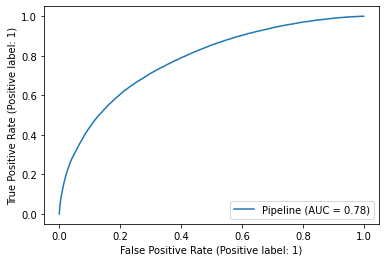

In [25]:
metrics.plot_roc_curve(model, x, y)